# Detection and Location Chain



**Abstract**: This hackathon project represents our effort to combine our existing machine learning and photogrametry efforts and further combine those efforts with both Cloud and Edge based solutions based upon Xilinx FPGA acceleration. A prior Trimble ICT (Intellegent Construction Tools) technology was explored in which a system of cameras use classical photogrammetric techniques to both automatically calibrate the placed cameras and to precision locate known objects within a test space to sub centimeter accuracy. One of the downsides to the existing technology being that real time operation was challenging due to compute requirements.

New efforts with machine learning by the Trimble Data group looked like a promising synergy. If machine learning could reduce the solution space for the photogrametric solution it might be possible to reduce the processing burden to acceptable levels. With these factors in mind, the Trimble team decided that the Xilinx hackathon would provide an excellent oppertunity to take the first steps in combining these technologies and learning how to use the varied Xilinx techologies.

Due to the time constraints of camera calibration, the team decided to move forward with a set of the data that Young-Jin used to previously vet the existing photogrametric system. Our initial hope was to use a TensorFlow system to provide the machine learning component of our test based on an AWS Ultrascale instance. That technology was unavailable for the hackathon, so during the event we trained a system based on a more stardard AWS Tensorflow instance and accessed that instance via Pynq networking. When TensorFlow is available to us on Ultrascale early next year we will push that part of the effort further.

The classification of the image pair produces a JSON metadata set that indicates the bounds of the photogrametric target region and a quality metric. As both code and neural net are new efforts, there will no doubt be some issues with system quality that will need to be resolved and understood over a larger period of time and will fall outside of the realm of this effort. Base photogrametric code for object location will be created and tested running solely on the Zynq. As time permits we will also attempt to explore using both OpenCV acceleration currently resident in the Pynq base overlay and possibly adding OpenCV HLS features if possible

The Team Trimble is composed of

* Roy Godzdanker – Trimble Product Architect for ICT
* Robert Banefield – Trimble Data Machine Learning Specialist
* Vinod Khare – Trimble ICT Photogrammetry
* Ashish Khare – Trimble Geomatics Photogrammetry
* Young-Jin Lee – Trimble ICT Photogrammetry
* Matt Compton - Trimble ICT Design Engineer


_NOTES_:

1. Bob's TensorFlow instance is sitting at the Trimble Data AWS instance. This is the slow and simple one for my debug effort. In the spirit of the hackathon, he started in training at the beginning of the night. This implies that it's capabilities were not exceptional at the beginning of the night and it will be better as the newly trained net is swapped in in the morning. Further tests back at the ranch will include testing this chain against some of the other theoretical models. The current net underperforms some previous efforts, further exploration is needed here
2. Once Xilinx gets their act together and completes their port of TensorFlow, this needs to be tossed to an AWS instance with an Ultrascale for benchmarking
3. We also need to explore the TensorFlow element as an edge device. Advances in Xilinx FPGA tools may make that cost competative with a GPU box.
4. The development path forward for the photogrammetry looks to be straight forward via OpenCV. There will be more pain points for functions not included in an easy Pynq base install. Xilinx HLS looks to be able to add needed acceleration functions but this needs further exploration going forward. We explored the idea of overly with python controled DMA, this is very promising

The following are globals used within this project To Change this to different image set, simply change the images indicated and run through the notebook again


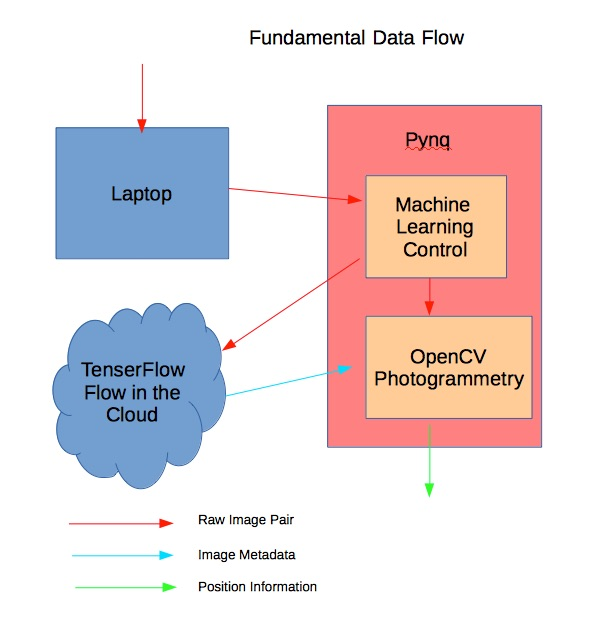

1. Camera data is sent to the system from a remote repository. This data was previously collected by a series of calibrated cameras in the Trimble lab. An image set consists of two images of the same target from two different cameras from which we have good position control and modeling.
2. The Camera Data is sent to the Pynq to being processing. The Pynq software drives the processing chain and produces 1 set of position data for each pair of camera images. The images are sent via web transfer into a TensorFlow cloud instance for classification
3. The TensorFlow cloud delivers metadata for the images that were transferred to it back to the Pynq via net transfer
4. The Pynq software uses the photogrammetric OpenCV software chain that we wrote to estimate and calculate geometric position of the measurement stick given the input from the learning system. In addition, images are displayed on the HDMI monitor and LCD display so we can see what is going on and to serve as a debug aid
5. The calculated position of the measurement stick is returned

In [13]:
## Imports

import cv2
import json
import matplotlib.pyplot as pyplot
import numpy
import matplotlib.patches  as patches
import pynq.overlays.base
import pynq.lib.arduino as arduino
import pynq.lib.video as video
import requests
import scipy
import sys
import PIL

In [14]:
## Config
gAWS_TENSORFLOW_INSTANCE = 'http://34.202.159.80'
gCAMERA0_IMAGE = "/home/xilinx/jupyter_notebooks/trimble-mp/CAM2_image_0032.jpg"
gCAMERA1_IMAGE = "/home/xilinx/jupyter_notebooks/trimble-mp/CAM3_image_0032.jpg"

Turn on the HDMI coming off the pink board. This is used in a fashion that is different than their primary test notes and may be difficult to complete during the time period. Specifically, the hdmi out is used without the input

In [15]:
base = pynq.overlays.base.BaseOverlay("base.bit")
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out
v = video.VideoMode(1920,1080,24)
hdmi_out.configure(v, video.PIXEL_BGR)
hdmi_out.start()
outframe = hdmi_out.newframe()

Using Pillow, pull in the chosen image for Camera 0

In [16]:
# Read images
image0BGR = cv2.imread(gCAMERA0_IMAGE)
image1BGR = cv2.imread(gCAMERA1_IMAGE)

image0 = image0BGR[...,::-1]
image1 = image1BGR[...,::-1]

Do exactly the same for the second image of the overlapping pair from camera 1

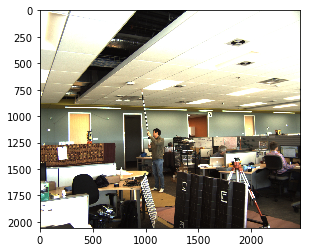

In [17]:
# Show image 0
pyplot.imshow(image0)
pyplot.show()

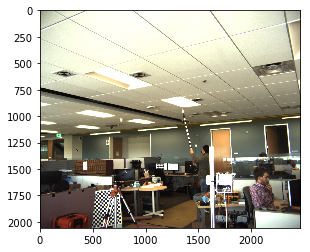

In [18]:
# Show image 1
pyplot.imshow(image1)
pyplot.show()

To send one of these to the HDMI, we are going to have to reformat it to fit the provided HDMI display

In [19]:
# Show image 0 on HDMI

# Need to resize it first
outframe[:] = cv2.resize(image0BGR, (1920, 1080));
hdmi_out.writeframe(outframe)

We will also display Young-Jin to the LCD screen. Why ? Because Young Jin does awesome work and deserves to be famous and also because I can

In [20]:
## Show image on LCD

# Open LCD object and clear
lcd = arduino.Arduino_LCD18(base.ARDUINO)
lcd.clear()

# Write image to disk
nw = 160
nl = 128
cv2.imwrite("/home/xilinx/small.jpg", cv2.resize(image0BGR, (nw,nl)))

# Display!
lcd.display("/home/xilinx/small.jpg",x_pos=0,y_pos=127,orientation=3,background=[255,255,255])

We now need to classify the images. This runs the remote version of TensorFlow on the image to get the bounding box on the stick. The following routine wraps this for simplicity. The spun up AWS TensorFlow instance is expecting to get be
sent a JPEG and will classify and send back the results as JSON.

The IP address of the spun up AWS instance is given by the global gAWS_TENSORFLOW_INSTANCE which is specified at the
beginning of this note book.

For stages of further development, this instance will be replaced by a one or more instances of an AWS Ultrascale instanciation once Xilinx gets their act together and gets TensorFlow running where I can get at it in the cloud. Depending on the level of responsiveness demanded by the customer, I may bring this node back from the cloud to the edge should circumstances due to poor or non-existant net access from a customers site.

In [21]:
def RemoteTensorFlowClassify(image_name_string):
    f = open(image_name_string,'rb')
    r = requests.put(gAWS_TENSORFLOW_INSTANCE, data=f)
    return json.loads(r.content.decode())

Actually call the defined function on images from camera 1 and camera 2. 

This gives us the bare minimum to kick in photogrametric processing of the image pair. This is appropraite for the proof of concept in the hackathon, but will be extended for an actual product methodology. 3 or more cameras will give me better geometric stability. Also, additional cameras may be used with enhansed code to avoid real world hazzards such as camera occlusion by other actors in the scene.

In [22]:
#Return the object that camera zero sees with the maximum score
cam0_json_return = RemoteTensorFlowClassify(gCAMERA0_IMAGE)
json0 = cam0_json_return["image_detection"]
max = 0.0
out = []
for var in json0['object']:
    if (var['score'] > max):
        out = var
json0 = out
json0

{'class_id': 1,
 'score': 0.9912543892860413,
 'xmax': 1125.3021841049194,
 'xmin': 949.6559209823608,
 'ymax': 2049.9720282554626,
 'ymin': 1536.3477578163147}

In [23]:
#Return the object that camera one sees with the maximum score
cam1_json_return = RemoteTensorFlowClassify(gCAMERA1_IMAGE)
json1 = cam1_json_return["image_detection"]
max = 0.0
out = []
for var in json1['object']:
    if (var['score'] > max):
        out = var
json1 = out
json1

{'class_id': 1,
 'score': 0.9984133243560791,
 'xmax': 929.8188982009888,
 'xmin': 559.6235628128052,
 'ymax': 2048.9980235099792,
 'ymin': 1594.049328327179}

Now so that we can see what we are going, we plot the bounding box that the Bob has found around the target. Due to Bob's engine being in the learning process when this is written I will probably have to hand pick a couple of images 
with good confidence scores so that the Photogrammetric OpenCV work can begin in parallel. The following routine adds the bounding box.
Note: I use lines here instead of the Pillow rectangle because the rectangle has no width parameter. Go figure.

In [30]:
def DrawRect(the_json,the_image, x1, x2, y1, y2 ): 
    # Currently offline until the TesnorFlow net is fixed
    #x1 = int(the_json["xmin"]) 
    #y1 = int(the_json["ymin"]) 
    #x2 = int(the_json["xmax"]) 
    #y2 = int(the_json["ymax"])
 
    
    fig, ax = pyplot.subplots(1)
    ax.imshow(the_image)
    rect = patches.Rectangle((x1,y1), (x2-x1), (y2-y1), linewidth = 1 , edgecolor = 'r', facecolor='none') 
    ax.add_patch(rect)
    pyplot.show()

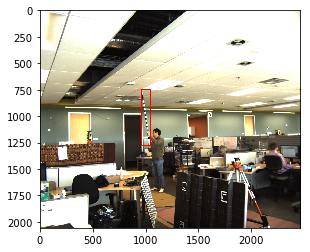

In [31]:
DrawRect(json0, image0, 955, 1045, 740, 1275)


Also display the bounding box for camera 1

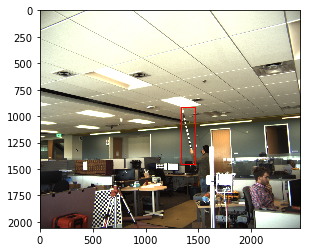

In [32]:
DrawRect(json1, image1, 1335, 1465, 910, 1455)


In [33]:
## Convert to grayscale
grayImage0 = cv2.cvtColor(image0, cv2.COLOR_RGB2GRAY)
grayImage1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)

In [34]:
def IsInsideROI(pt, the_json, x1, x2, y1, y2):
#    x_min = int(the_json["object"]["xmin"])
#    y_min = int(the_json["object"]["ymin"])
#    x_max = int(the_json["object"]["xmax"])
#    y_max = int(the_json["object"]["ymax"])
 
    x_min = x1
    y_min = y1
    x_max = x2
    y_max = y2
    if(pt[0]>=x_min and pt[0] <=x_max and pt[1]>=y_min and pt[1]<=y_max):
        return True
    else: 
        return False

In [35]:
## Detect keypoints
Brisk = cv2.BRISK_create()

keyPoints0 = Brisk.detect(grayImage0)
keyPoints1 = Brisk.detect(grayImage1)

In [36]:
## Find keypoints inside ROI
roiKeyPoints0 = numpy.asarray([k for k in keyPoints0 if IsInsideROI(k.pt,json0, 955, 1045, 740, 1275 )])
roiKeyPoints1 = numpy.asarray([k for k in keyPoints1 if IsInsideROI(k.pt,json1, 1335, 1465, 910, 1455 )])

In [37]:
## Compute descriptors for keypoitns inside ROI
[keyPoints0, desc0] = Brisk.compute(grayImage0, roiKeyPoints0);
[keyPoints1, desc1] = Brisk.compute(grayImage1, roiKeyPoints1);

In [38]:
## Find matches of ROI keypoints
BF = cv2.BFMatcher()
matches = BF.match(desc0, desc1)

In [39]:
## Extract pixel coordinates from matched keypoints

x_C0 = numpy.asarray([keyPoints0[match.queryIdx].pt for match in matches])
x_C1 = numpy.asarray([keyPoints1[match.trainIdx].pt for match in matches])

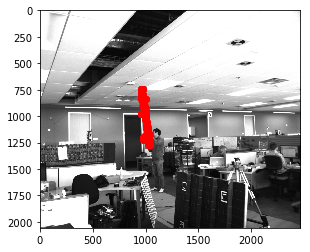

In [40]:
# Show image 0 with the matched keypoints
pyplot.imshow(grayImage0, cmap = 'gray')
pyplot.plot(x_C0[:, 0], x_C0[:, 1], 'ro')
pyplot.show()

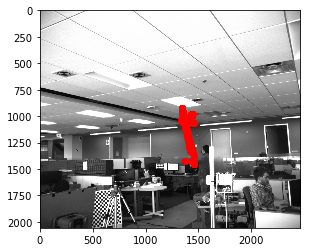

In [41]:
# Show image 1 with matched keypoints
pyplot.imshow(grayImage1, cmap = 'gray')
pyplot.plot(x_C1[:, 0], x_C1[:, 1], 'ro')
pyplot.show()

Full mesh triangularization is off line until we reconsile the camera calibration. There was an issue discovered during the hackathon that needs to be examined in teh lab setup s the code below this will not function until we reconsile the camera calibration config.

In [44]:
# Triangulate points

# We need projection matrices for camera 0 and camera 1
f = 8.350589e+000 / 3.45E-3
cx = -3.922872e-002 / 3.45E-3
cy = -1.396717e-004 / 3.45E-3
K_C0 = numpy.transpose(numpy.asarray([[f, 0, 0], [0, f, 0], [cx, cy, 1]]))
k_C0 = numpy.asarray([1.761471e-003, -2.920431e-005, -8.341438e-005, -9.470247e-006, -1.140118e-007])

[R_C0, J] = cv2.Rodrigues(numpy.asarray([1.5315866633, 2.6655790203, -0.0270418317]))
T_C0 = numpy.transpose(numpy.asarray([[152.9307390952, 260.3066944976, 351.7405264829]])) * 1000

f = 8.259861e+000 / 3.45E-3
cx = 8.397453e-002 / 3.45E-3
cy = -2.382030e-002 / 3.45E-3
K_C0 = numpy.transpose(numpy.asarray([[f, 0, 0], [0, f, 0], [cx, cy, 1]]))
K_C1 = numpy.asarray([1.660053e-003, -2.986269e-005, -7.461966e-008, -2.247960e-004, -2.290483e-006])

[R_C1, J] = cv2.Rodrigues(numpy.asarray([1.4200199799, -2.6113619450, -0.1371719827]))
T_C1 = numpy.transpose(numpy.asarray([[146.8718203137, 259.9661037150, 351.5832136366]])) * 1000

P_C0 = numpy.dot(K_C0,numpy.concatenate((R_C0, T_C0), 1))
P_C1 = numpy.dot(K_C1,numpy.concatenate((R_C1, T_C1), 1))

ValueError: shapes (5,) and (3,4) not aligned: 5 (dim 0) != 3 (dim 0)

In [43]:
# Compute 3D coordinates of detected points
X_C0 = cv2.convertPointsFromHomogeneous(numpy.transpose(cv2.triangulatePoints(P_C0, P_C1, numpy.transpose(x_C0), numpy.transpose(x_C1))))

NameError: name 'P_C1' is not defined